## Setup

### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflowjs as tfjs

keras = tf.keras

### Util Functions

In [17]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

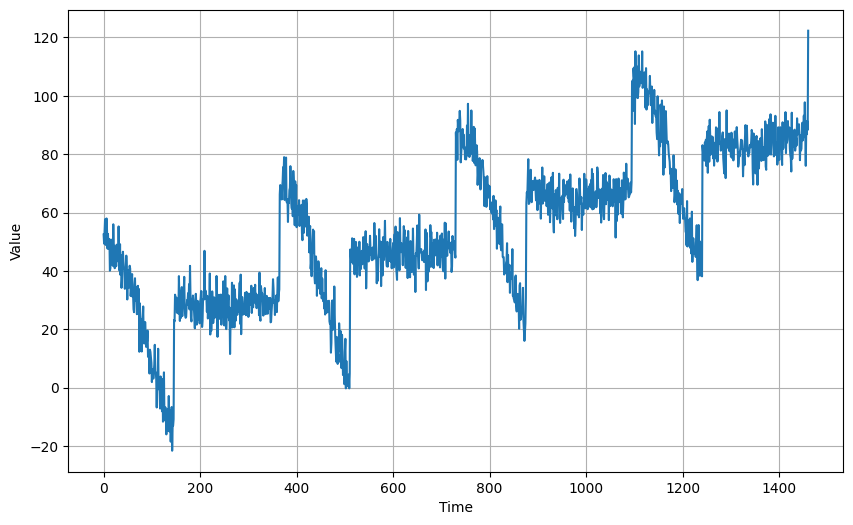

In [5]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

### Data Split

In [6]:
# SPLIT FROM A FRACTION OF TIME
split_time = 1000
x_train = series[:split_time]
x_valid = series[split_time:]

## Convolutional Forecasting

In [7]:
# THIS IS CELL IS TO DETECT THE BEST LEARNING RATE FOR THE MODEL
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
# init model 
model = keras.models.Sequential()
# input layer
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
# wavenet architecture - ref --> https://medium.com/@satyam.kumar.iiitv/understanding-wavenet-architecture-361cc4c2d623
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
# output layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
# iterate over several learning rates 
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
# define the optimizer Adaptive Moment Estimation (adam)
optimizer = keras.optimizers.Adam(lr=1e-4)
# compile and train
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 58ms/step - loss: 41.9132 - mae: 42.4122 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 40ms/step - loss: 41.7299 - mae: 42.2290 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 33ms/step - loss: 41.5420 - mae: 42.0412 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 43ms/step - loss: 41.3472 - mae: 41.8464 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 41.1228 - mae: 41.6221 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 36ms/step - loss: 40.8321 - mae: 41.3315 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 31ms/step - loss: 40.4230 - mae: 40.9224 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 32ms/step - loss: 39.8490 - mae: 40.3480 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 31ms/step - loss: 38.9851 - mae: 39.4836 - lr: 1.8

(0.0001, 0.1, 0.0, 30.0)

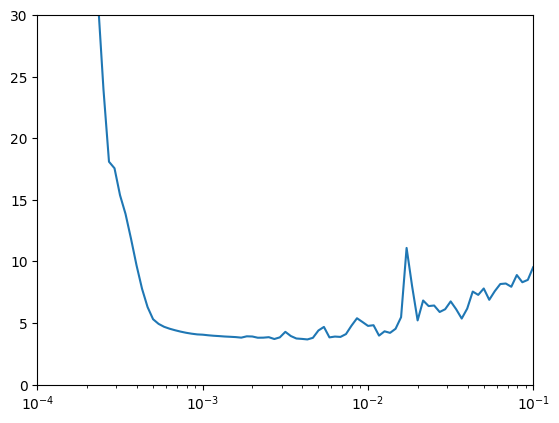

In [8]:
# PLOT THE LEARNING RATES CURVE
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [9]:
# THIS CELL IS THE ACTUAL MODEL TRAINING 
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)
# init model
model = keras.models.Sequential()
# input layer
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
# wavenet architecture - ref --> https://medium.com/@satyam.kumar.iiitv/understanding-wavenet-architecture-361cc4c2d623
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
# output layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
# define the optimizer Adaptive Moment Estimation (adam)
optimizer = keras.optimizers.Adam(lr=3e-4)
# compile the model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
# define how to save best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
# regularization with early stopping and patiente
early_stopping = keras.callbacks.EarlyStopping(patience=50)
# fit (train) the model 
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 3s 151ms/step - loss: 39.8593 - mae: 40.3582 - val_loss: 65.4239 - val_mae: 65.9239
Epoch 2/500


/Users/manriqs/Desktop/all/Development/portfolio/CNNForecasting/CNNForecast/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 50ms/step - loss: 29.8039 - mae: 30.3021 - val_loss: 33.3011 - val_mae: 33.7985
Epoch 3/500
8/8 [==============================] - 0s 49ms/step - loss: 18.4064 - mae: 18.9008 - val_loss: 30.0805 - val_mae: 30.5783
Epoch 4/500
8/8 [==============================] - 0s 49ms/step - loss: 15.6958 - mae: 16.1885 - val_loss: 24.3543 - val_mae: 24.8490
Epoch 5/500
8/8 [==============================] - 0s 51ms/step - loss: 13.4448 - mae: 13.9343 - val_loss: 18.2693 - val_mae: 18.7625
Epoch 6/500
8/8 [==============================] - 1s 51ms/step - loss: 11.1066 - mae: 11.5954 - val_loss: 15.0816 - val_mae: 15.5710
Epoch 7/500
8/8 [==============================] - 0s 47ms/step - loss: 8.6745 - mae: 9.1594 - val_loss: 10.2776 - val_mae: 10.7634
Epoch 8/500
8/8 [==============================] - 0s 49ms/step - loss: 6.7671 - mae: 7.2486 - val_loss: 8.2286 - val_mae: 8.7139
Epoch 9/500
8/8 [==============================] - 0s 46ms/step - loss: 5.7112 -

In [10]:
# load the best model
model = keras.models.load_model("my_checkpoint.h5")

## Predictions

In [18]:
# perform predictions
pred_series = series[..., np.newaxis]
cnn_forecast = model_forecast(model, pred_series, window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

[[ 52.48357077]
 [ 49.35275206]
 [ 53.31473872]
 ...
 [ 91.37325376]
 [ 88.32382529]
 [122.30772008]]
44/44 [==============================] - 0s 5ms/step


In [22]:
pred_series

array([[ 52.48357077],
       [ 49.35275206],
       [ 53.31473872],
       ...,
       [ 91.37325376],
       [ 88.32382529],
       [122.30772008]])

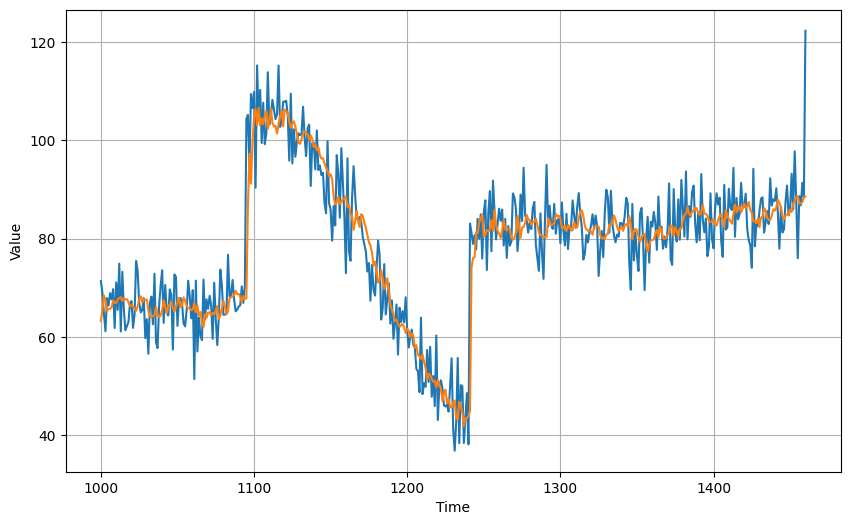

In [15]:
# plot predictions results

time_train = time[:split_time]
time_valid = time[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [13]:
# check the Mean Absolute Error (MAE)
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.619696

## Export Model

In [ ]:
# export to TF.js layers format
# tfjs.converters.save_keras_model(model, './cnn_forecasting')